In [ ]:
# TODO
# - try tracking by making mesh of object and bacground from segmentation mask


In [2]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from functools import partial
import importlib
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np


In [806]:
b3d.rr_init("interactive")
key = jax.random.PRNGKey(0)
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
scene_id = 48
image_id = 100

num_scenes = b3d.io.data_loader.get_ycbv_num_test_images(ycb_dir, scene_id)

# image_ids = [image] if image is not None else range(1, num_scenes, FRAME_RATE)
image_ids = range(1, num_scenes + 1, 100)
all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, image_ids)



meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.2
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)

IDX = 0
rendered_rgbds = [
    renderer.render_rgbd_from_mesh(meshes[IDX].transform(all_data[T]["camera_pose"].inv() @ all_data[T]["object_poses"][IDX]))
    for T in range(len(all_data))
]

observed_rgbd_scaled_down = b3d.resize_image(all_data[0]["rgbd"], renderer.height, renderer.width)

100%|██████████| 23/23 [00:09<00:00,  2.44it/s]


/opt/conda/envs/b3d/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


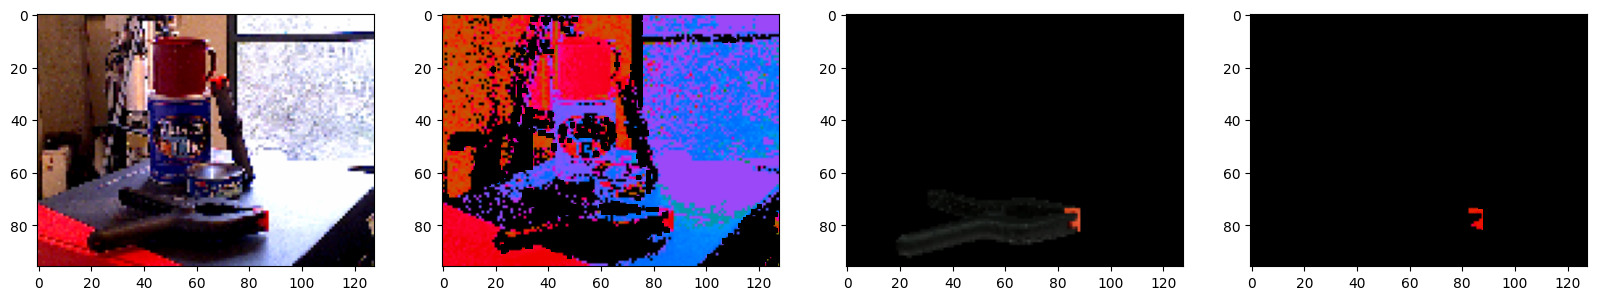

In [622]:
info = info_from_trace(trace)
latent_labd = info["latent_color_space_d"]
observed_labd = info["observed_color_space_d"]

def normalize_lab(lab):
    l = lab[...,0:1]
    ab = lab[...,1:3]
    length = jnp.linalg.norm(ab + 0.0001, axis=-1, keepdims=True)
    black_or_white = length < 20.0
    black = black_or_white * (l < 50.0)
    white = black_or_white * (l >= 50.0)
    ab_normalized = ab / length * 100.0

    return jnp.concatenate([(black * 0.0001 + white * 99.99 + (1.0 - black_or_white)* 50.0), (~black) * ab_normalized + 0.001], axis=-1)

def normalize_labd(labd):
    return jnp.concatenate([normalize_lab(labd[..., :3]), labd[..., 3:4]], axis=-1)



fig,ax = plt.subplots(1,4, figsize=(20,10))
ax[0].imshow(trace.get_retval()["rgbd"][...,:3])
ax[1].imshow(b3d.colors.lab_to_rgb(normalize_lab(observed_labd)))
ax[2].imshow(trace.get_retval()["latent_rgbd"][...,:3])
ax[3].imshow(b3d.colors.lab_to_rgb(normalize_lab(latent_labd)))

normalized_observed_lab = normalize_lab(observed_labd)
normalized_latent_lab = normalize_lab(latent_labd)

rr.log("img", rr.Image(normalize_lab(observed_labd)))
rr.log("img/latent", rr.Image(normalize_lab(latent_labd)))
rr.log("img/rgb", rr.Image(trace.get_retval()["rgbd"][...,:3]))
rr.log("img/rgb/latent", rr.Image(trace.get_retval()["latent_rgbd"][...,:3]))
angle = jnp.arctan2(normalized_observed_lab[...,1], normalized_observed_lab[...,2]) * 180.0 / jnp.pi
latent_angle = jnp.arctan2(normalized_latent_lab[...,1], normalized_latent_lab[...,2]) * 180.0 / jnp.pi
rr.log("img/angle", rr.DepthImage(jnp.arctan2(normalized_observed_lab[...,1], normalized_observed_lab[...,2]) * 180.0 / jnp.pi) )
rr.log("img/angle/latent", rr.DepthImage(jnp.arctan2(normalized_latent_lab[...,1], normalized_latent_lab[...,2]) * 180.0 / jnp.pi))
rr.log("img/angle/diff", rr.DepthImage(jnp.minimum(jnp.abs(angle - latent_angle), 360.0 - jnp.abs(angle - latent_angle))))

In [815]:
lower_bound = jnp.array([0.0, -128.0, -128.0, 0.0])
upper_bound = jnp.array([100.0, 128.0, 128.0, 3.0])
convert_rgbd_to_color_space = lambda x: normalize_labd(b3d.colors.rgbd_to_labd(x))
convert_color_space_to_rgbd = lambda x: b3d.colors.labd_to_rgbd(x)


# lower_bound = jnp.array([0.0, -0.0, -0.0, 0.0])
# upper_bound = jnp.array([1.0, 1.0, 1.0, 10.0])
# convert_rgbd_to_color_space = lambda x: x
# convert_color_space_to_rgbd = lambda x: x

# def sample_likelihood_func()

def intermediate_likelihood_func(observed_rgbd, latent_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    fx = likelihood_args["fx"]
    fy = likelihood_args["fy"]
    
    outlier_probability_background  = likelihood_args[f"outlier_probability_background"]
    lightness_variance_background  = likelihood_args[f"lightness_variance_background"]
    color_variance_background  = likelihood_args[f"color_variance_background"]
    depth_variance_background  = likelihood_args[f"depth_variance_background"]

    outlier_probability_0  = likelihood_args[f"outlier_probability_0"]
    lightness_variance_0  = likelihood_args[f"lightness_variance_0"]
    color_variance_0  = likelihood_args[f"color_variance_0"]
    depth_variance_0  = likelihood_args[f"depth_variance_0"]


    inlier_variances_background = jnp.array([lightness_variance_background, color_variance_background, color_variance_background, depth_variance_background])
    inlier_variances_0 = jnp.array([lightness_variance_0, color_variance_0, color_variance_0, depth_variance_0])
    outlier_variances = jnp.array([1000000.0, 1000000.0, 1000000.0, 1000000.0])

    all_inlier_variances = jnp.stack([inlier_variances_background, inlier_variances_0])
    all_outlier_probabilities = jnp.array([outlier_probability_background, outlier_probability_0])

    image_height, image_width = observed_rgbd.shape[:2]

    # row_coordinates = jax.vmap(genjax.categorical.sample,in_axes=(0, 0,))(
    #     jax.random.split(key, k),
    #     jnp.ones((k, image_height))
    # )
    # column_coordinates = jax.vmap(genjax.categorical.sample, in_axes=(0, 0,))(
    #     jax.random.split(key, k),
    #     jnp.ones((k, image_width))
    # )

    mesh_index = 1 * (latent_rgbd[..., 3] >  0.)

    outlier_probability_adjusted = all_outlier_probabilities[mesh_index]
    inlier_variances = all_inlier_variances[mesh_index]

    observed_labd = b3d.colors_r

    observed_color_space_d = convert_rgbd_to_color_space(observed_rgbd)
    latent_color_space_d = convert_rgbd_to_color_space(latent_rgbd)

    subset_observed = observed_color_space_d
    subset_observed_rescaled = (subset_observed - lower_bound) / (upper_bound - lower_bound)
    rendered_values_rescaled = (latent_color_space_d - lower_bound) / (upper_bound - lower_bound)


    scores_inlier = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, 0, 0, None, None))(
        subset_observed_rescaled, rendered_values_rescaled, inlier_variances,
        0.0, 1.0
    )
    scores_outlier = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, None, None, None, None))(
        subset_observed_rescaled, 0.5, outlier_variances,
        0.0, 1.0
    )

    # scores_inlier_merged = jax.nn.logsumexp(scores_inlier[..., :3] + jnp.log(1/3), axis=-1) + scores_inlier[..., 3] + jnp.log(1.0 - outlier_probability_adjusted) 
    # scores_outlier_merged = jax.nn.logsumexp(scores_outlier[..., :3] + jnp.log(1/3), axis=-1) + scores_outlier[..., 3] + jnp.log(outlier_probability_adjusted)

    scores_inlier_merged = scores_inlier[...,:].sum(-1) + jnp.log(1.0 - outlier_probability_adjusted) 
    scores_outlier_merged = scores_outlier[...,:].sum(-1) + jnp.log(outlier_probability_adjusted)

    latent_depth = latent_rgbd[..., 3]
    latent_areas = (latent_depth / fx) * (latent_depth / fy)

    pixelwise_score = jnp.logaddexp(scores_inlier_merged, scores_outlier_merged) 
    pixelwise_score_full = jnp.zeros((image_height, image_width))
    # pixelwise_score_full = pixelwise_score_full.at.set(pixelwise_score)
    pixelwise_score_full = pixelwise_score * (observed_rgbd[..., 3] > 0.)

    # pixelwise_score_full = pixelwise_score_full * latent_areas

    return {
        "score": pixelwise_score_full.sum(),
        "observed_color_space_d": observed_color_space_d,
        "latent_color_space_d": latent_color_space_d,
        "pixelwise_score": pixelwise_score_full,
    }

import b3d.chisight.dense.dense_model
b3d.reload(b3d.chisight.dense.dense_model)
model, viz_trace, info_from_trace = b3d.chisight.dense.dense_model.make_dense_multiobject_model(
    renderer, intermediate_likelihood_func
)
importance_jit = jax.jit(model.importance)


grid3 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True, True, True))
grid4 = b3d.multivmap(b3d.update_choices_get_score, (False, False, False, True, True, True, True))

In [816]:
IDX = 4
likelikood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "k": Pytree.const(10000),
}

T = 22
choicemap = genjax.ChoiceMap.d(
    {
        "rgbd": b3d.resize_image(all_data[T]["rgbd"], renderer.height, renderer.width),
        # "rgbd": rendered_rgbds[0],
        "object_pose_0": all_data[T]["object_poses"][IDX],
        "camera_pose": all_data[T]["camera_pose"],
        "outlier_probability_background": 1.0,
    }
)

trace = importance_jit(
    key, 
    choicemap,
    ({"num_objects": Pytree.const(1), "meshes": [meshes[IDX]], "likelihood_args": likelikood_args},)
)[0]
print(trace.get_score())
viz_trace(trace)


1193.9121


In [826]:
for arguments in [
    # Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",)),
    Pytree.const(("outlier_probability_0", "lightness_variance_0", "color_variance_0", "depth_variance_0",)),
]:
    key = jax.random.split(key, 2)[-1]
    outlier_probability_sweep = jnp.linspace(0.01, 0.1, 30)
    lightness_variance_sweep = jnp.linspace(0.2, 1.0, 20)
    color_variance_sweep = jnp.linspace(0.01, 0.05, 15)
    depth_variance_sweep = jnp.linspace(0.001, 0.002, 15)
    # arguments = Pytree.const(("outlier_probability_background", "lightness_variance_background", "color_variance_background", "depth_variance_background",))
    sweeps = [outlier_probability_sweep, lightness_variance_sweep, color_variance_sweep, depth_variance_sweep]

    scores = grid4(
        trace, key,
        arguments,
        *sweeps
    )
    sampled_indices = jax.vmap(
        jnp.unravel_index,
        in_axes=(0,None)
    )(jax.random.categorical(key, scores.reshape(-1),shape=(1000,)), scores.shape)
    sampled_parameters = jnp.vstack([
        sweep[indices]
        for indices, sweep in zip(sampled_indices, sweeps)
    ]).T

    print(sampled_parameters[0])
    trace = b3d.update_choices(trace, key,
        arguments,
        # 0.05, 1.0, 0.02, 0.01
        *sampled_parameters[0]
    )
    print(trace.get_score())
    viz_trace(trace)
    info_from_trace(trace)["score"]

[0.1   0.2   0.01  0.002]
3570.5098


In [844]:
key = jax.random.split(key, 2)[-1]
N = 1000
B = 5
keys = jax.random.split(key, N*B)

# sampled_poses =  Pose.concatenate_poses([Pose.sample_gaussian_vmf_pose_vmap(
#     keys, trace.get_choices()["object_pose_0"], 0.05, 800.0,
# ), trace.get_choices()["object_pose_0"][None,...]])

sampled_poses =  Pose.concatenate_poses([Pose.sample_gaussian_vmf_pose_vmap(
    keys, trace.get_choices()["object_pose_0"], 0.05, 800.0,
)])

scores = jnp.concatenate([
    b3d.enumerate_choices_get_scores(
        trace,key, Pytree.const(("object_pose_0",)),
        sampled_poses[k]
    )
    for k in jnp.array_split(jnp.arange(len(sampled_poses)), B)
])

sampled_indices = jax.random.categorical(key, scores * 0.1 , shape=(100,))
print(sampled_indices)
new_trace = b3d.update_choices(trace, key, Pytree.const(("object_pose_0",)),
                               sampled_poses[sampled_indices[0]])
viz_trace(new_trace)
print(new_trace.get_score())
info_from_trace(new_trace)["score"]

[1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115 1115
 1115 1115]
4420.2373


Array(4432.287, dtype=float32)

In [466]:
print(((trace.get_retval()["latent_rgbd"][...,3]>0) * info_from_trace(trace)["pixelwise_score"]).mean())
print(((new_trace.get_retval()["latent_rgbd"][...,3]>0) * info_from_trace(new_trace)["pixelwise_score"]).mean())

Array(0.47610688, dtype=float32)

In [34]:
new_trace.get_choices()

XorChm(
  c1=XorChm(
    c1=XorChm(
      c1=XorChm(c1=XorChm(c1=XorChm(c1=StaticChm(addr='outlier_probability', c=ValueChm(v=<jax.Array(0.85433906, dtype=float32)>)), c2=StaticChm(addr='lightness_variance', c=ValueChm(v=<jax.Array(0.76743054, dtype=float32)>))), c2=StaticChm(addr='color_variance', c=ValueChm(v=<jax.Array(0.9140065, dtype=float32)>))), c2=StaticChm(addr='depth_variance', c=ValueChm(v=<jax.Array(0.5500286, dtype=float32)>))),
      c2=StaticChm(addr='object_pose_0', c=ValueChm(v=Pose(position=Array([-0.08521235,  0.00545534,  0.07130677], dtype=float32), quaternion=Array([ 0.6857101 , -0.02822381,  0.72732246,  0.00267684], dtype=float32)))),
    ),
    c2=StaticChm(
      addr='camera_pose',
      c=ValueChm(v=Pose(position=Array([-0.633828  , -0.20314899,  0.58637404], dtype=float32), quaternion=Array([ 0.72074157, -0.5602933 ,  0.20024239, -0.3556768 ], dtype=float32))),
    ),
  ),
  c2=StaticChm(
    addr='rgbd',
    c=ValueChm(
      v=<jax.Array float32(48, 64, 4

In [79]:
trace = b3d.update_choices(
    trace,
    key,
    arguments,
    *sampled_parameters[0]
)
print(sampled_parameters[0])
trace.get_choices()["outlier_probability"], trace.get_choices()["lightness_variance"], trace.get_choices()["color_variance"], trace.get_choices()["depth_variance"]

[0.79251724 0.5267895  1.         0.07235715]


(Array(0.79251724, dtype=float32),
 Array(0.5267895, dtype=float32),
 Array(1., dtype=float32),
 Array(0.07235715, dtype=float32))

In [46]:
f(
    trace, key,
    Pytree.const(("outlier_probability", "color_variance", "object_pose_0")),
    jnp.array([0.1, 0.2, 0.3]), jnp.array([0.2, 0.01]), all_data[0]["object_poses"][IDX][None,...]
).shape

(3, 2, 1)

In [103]:
def plot_trace(trace):
    fig, ax = plt.subplots(1, 5, figsize=(10, 5))

    ax[0].imshow(trace.get_retval()["rendered_rgbd"][..., :3])
    ax[0].axis('off')

    ax[1].imshow(trace.get_retval()["sampled_rgbd"][..., :3])
    ax[1].axis('off')

    ax[2].matshow(trace.get_retval()["sampled_rgbd"][..., 3])
    ax[2].axis('off')


    ax[3].imshow(trace.get_retval()["observed_rgbd"][..., :3])
    ax[3].axis('off')


    ax[4].imshow(trace.get_retval()["observed_rgbd"][..., :3],alpha=1.0)
    ax[4].imshow(trace.get_retval()["rendered_rgbd"][..., :3],alpha=0.5)
    ax[4].axis('off')
    return fig


def plot_interactive(trace):
    def _make_viz(outlier_probability, inlier_lightness_variance, inlier_color_variance, inlier_depth_variance):
        choicemap = genjax.ChoiceMap.d(
            {
                "outlier_probability": outlier_probability,
                "inlier_lightness_variance": inlier_lightness_variance,
                "inlier_color_variance": inlier_color_variance,
                "inlier_depth_variance": inlier_depth_variance,
            }
        )
        modified_trace = update_jit(
            key,
            trace,
            choicemap
        )[0]
        plot_trace(modified_trace)

    interact(_make_viz,
        k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
        outlier_probability = widgets.FloatSlider(
            value=trace.get_choices()["outlier_probability"],
            min=outlier_probability_sweep.min(),
            max=outlier_probability_sweep.max(),
            step=0.01
        ),
        inlier_lightness_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_lightness_variance"],
            min=inlier_lightness_variance_sweep.min(),
            max=inlier_lightness_variance_sweep.max(),
            step=0.01
        ),
        inlier_color_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_color_variance"],
            min=inlier_color_variance_sweep.min(),
            max=inlier_color_variance_sweep.max(),
            step=0.01
        ),
        inlier_depth_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_depth_variance"],
            min=inlier_depth_variance_sweep.min(),
            max=inlier_depth_variance_sweep.max(),
            step=0.01
        ),
    )


In [132]:

@genjax.gen
def ray_model(args):
    likelihood_args = args["likelihood_args"]
    pose = (
        uniform_pose(jnp.ones(3) * -100.0, jnp.ones(3) * 100.0) @ f"object_pose_0"
    )
    rendered_rgbd = renderer.render_rgbd_from_mesh(meshes[IDX].transform(pose))
    rendered_color_space_d = convert_rgbd_to_color_space(rendered_rgbd)

    k = likelihood_args["k"].const
    image_height, image_width = rendered_color_space_d.shape[0], rendered_color_space_d.shape[1]
    image_height = Pytree.const(image_height)
    image_width = Pytree.const(image_width)

    row_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_height.const))
    )  @ "row_coordinates"
    column_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_width.const))
    ) @ "column_coordinates"


    outlier_probability = genjax.uniform(0.0, 1.0) @ "outlier_probability"
    inlier_color_variance = genjax.uniform(0.01, 100.0) @ "inlier_color_variance"
    inlier_lightness_variance = genjax.uniform(0.01, 100.0) @ "inlier_lightness_variance"
    inlier_depth_variance = genjax.uniform(0.01, 1000.0) @ "inlier_depth_variance"

    inlier_variances = jnp.array([inlier_lightness_variance, inlier_color_variance, inlier_color_variance, inlier_depth_variance])
    outlier_variances = jnp.array([1000000.0, 1000000.0, 1000000.0, 1000000.0])


    sampled_color_space_d = masked_k_image_likelihood_marginalize_outlier_prob.sample(
        key,
        row_coordinates,
        column_coordinates,
        rendered_color_space_d,
        inlier_variances,
        outlier_variances,
        outlier_probability,
        lower_bound, upper_bound,
        image_height, image_width
    )

    observed_color_space_d = masked_k_image_likelihood_marginalize_outlier_prob(
        row_coordinates,
        column_coordinates,
        rendered_color_space_d,
        inlier_variances,
        outlier_variances,
        outlier_probability,
        lower_bound, upper_bound,
        image_height, image_width
    ) @ "observed_color_space_d"

    observed_rgbd = convert_color_space_to_rgbd(observed_color_space_d)
    sampled_rgbd = convert_color_space_to_rgbd(sampled_color_space_d)

    return {
        "rendered_rgbd": rendered_rgbd,
        "sampled_rgbd": sampled_rgbd,
        "observed_rgbd": observed_rgbd,

        "rendered_color_space_d": rendered_color_space_d,
        "sampled_color_space_d": sampled_color_space_d,
        "observed_color_space_d": observed_color_space_d,
    }

importance_jit = jax.jit(ray_model.importance)
update_jit = jax.jit(ray_model.update)




def plot_interactive(trace):
    def _make_viz(outlier_probability, inlier_lightness_variance, inlier_color_variance, inlier_depth_variance):
        choicemap = genjax.ChoiceMap.d(
            {
                "outlier_probability": outlier_probability,
                "inlier_lightness_variance": inlier_lightness_variance,
                "inlier_color_variance": inlier_color_variance,
                "inlier_depth_variance": inlier_depth_variance,
            }
        )
        modified_trace = update_jit(
            key,
            trace,
            choicemap
        )[0]
        plot_trace(modified_trace)

    interact(_make_viz,
        k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
        outlier_probability = widgets.FloatSlider(
            value=trace.get_choices()["outlier_probability"],
            min=outlier_probability_sweep.min(),
            max=outlier_probability_sweep.max(),
            step=0.01
        ),
        inlier_lightness_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_lightness_variance"],
            min=inlier_lightness_variance_sweep.min(),
            max=inlier_lightness_variance_sweep.max(),
            step=0.01
        ),
        inlier_color_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_color_variance"],
            min=inlier_color_variance_sweep.min(),
            max=inlier_color_variance_sweep.max(),
            step=0.01
        ),
        inlier_depth_variance = widgets.FloatSlider(
            value=trace.get_choices()["inlier_depth_variance"],
            min=inlier_depth_variance_sweep.min(),
            max=inlier_depth_variance_sweep.max(),
            step=0.01
        ),
    )

@jax.jit
def update_parameters(
    trace,
    key,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
):
    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
        }
    )
    return trace.update(
        key, 
        choicemap,
    )[0]

@jax.jit
def update_parameters_get_score(
    trace,
    key,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
):
    return update_parameters(
        trace,
        key,
        outlier_probability,
        inlier_lightness_variance,
        inlier_color_variance,
        inlier_depth_variance,
    ).get_score()

vmapped_grid = jax.jit(b3d.multivmap(update_parameters_get_score, args=(False, False, True, True, True, True)))


outlier_probability_sweep = jnp.linspace(0.0, 1.0, 30)
inlier_lightness_variance_sweep = jnp.linspace(1.0, 60.0, 20)
inlier_color_variance_sweep = jnp.linspace(1.0, 20.0, 20)
inlier_depth_variance_sweep = jnp.linspace(0.005, 0.04, 15)


key = jax.random.split(key, 2)[-1]
likelikood_args = {
    "fx": fx,
    "fy": fy,
    "k": Pytree.const(20000),
}

choicemap = genjax.ChoiceMap.d(
    {
        "outlier_probability": 0.1,
        "inlier_lightness_variance": 0.1,
        "inlier_color_variance": 0.1,
        "inlier_depth_variance": 0.1,
        "observed_color_space_d": convert_rgbd_to_color_space(observed_rgbd_scaled_down),
    }
)

trace = importance_jit(
    key, 
    choicemap,
    ({"likelihood_args": likelikood_args},)
)[0]

In [133]:
T = 5
trace = b3d.update_choices(
    trace,
    key,
    Pytree.const(("object_pose_0",)),
    all_data[T]["camera_pose"].inv() @ all_data[T]["object_poses"][IDX]
)


In [134]:
key = jax.random.split(key, 2)[-1]

sweeps = [
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    inlier_color_variance_sweep,
    inlier_depth_variance_sweep,
]
scores = vmapped_grid(
    trace,
    key,
    *sweeps
)
sampled_indices = jax.vmap(
    jnp.unravel_index,
    in_axes=(0,None)
)(jax.random.categorical(key, scores.reshape(-1),shape=(100,)), scores.shape)
sampled_parameters = [
    sweep[indices]
    for indices, sweep in zip(sampled_indices, sweeps)
]
trace = update_parameters(
    trace,
    key,
    *[param[0] for param in sampled_parameters]
)
print([i[0].item() for i in sampled_parameters])
print(trace.get_score())
plot_interactive(trace)

[0.03448275849223137, 38.26315689086914, 20.0, 0.03999999910593033]
-164811.3


interactive(children=(FloatSlider(value=0.03448275849223137, description='outlier_probability', max=1.0, step=…

In [128]:
from b3d.bayes3d.enumerative_proposals import gvmf_and_select_best_move

saved_trace = trace
potential_traces = []
for var in [0.03, 0.02, 0.01, 0.005, 0.03, 0.02, 0.01, 0.005]:
    trace = saved_trace
    trace, key = gvmf_and_select_best_move(
        trace, key, var, 700.0, "object_pose_0", 700
    )
    trace, key = gvmf_and_select_best_move(
        trace, key, var, 700.0, "object_pose_0", 700
    )
    trace, key = gvmf_and_select_best_move(
        trace, key, var, 1000.0, "object_pose_0", 700
    )
    trace, key = gvmf_and_select_best_move(
        trace, key, var, 1000.0, "object_pose_0", 700
    )
    potential_traces.append(trace)
scores = jnp.array([t.get_score() for t in potential_traces])
trace = potential_traces[scores.argmax()]
print(trace.get_score())
plot_interactive(trace)

-157607.31


interactive(children=(FloatSlider(value=0.0, description='outlier_probability', max=1.0, step=0.01), FloatSlid…

In [15]:
rendered_rgbd = trace.get_retval()["rendered_rgbd"]
observed_rgbd = trace.get_retval()["observed_rgbd"]
rendered_color_space_d = trace.get_retval()["rendered_color_space_d"]
observed_color_space_d = trace.get_retval()["observed_color_space_d"]

In [38]:
w = 100.0
print(jnp.log(1/w))
print(genjax.truncated_normal.logpdf(
    0.2 *w, 0.3 * w, 0.05 * w, -w/2, w/2
))

-4.6051702
-4.528345


In [ ]:
trace.get_retval()["observed_color_space_d"].shape

In [ ]:
no_mesh_surface = (rendered_labd[...,3] == 0.0)

inlier_variances = jnp.array([60.0, 60.0, 60.0, 0.6])

lower_bound = jnp.array([0.0, -100.0, -100.0, 0.0])
upper_bound = jnp.array([100.0, 100.0, 100.0, 20.0])

outlier_variances = jnp.ones(4) * 1000000.0

scores_inlier = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, 0, None, None, None))(
    observed_labd.reshape(-1, 4), rendered_labd.reshape(-1,4), inlier_variances,
    lower_bound, upper_bound
)
scores_outlier = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, None, None, None, None))(
    observed_labd.reshape(-1, 4), (lower_bound + upper_bound) / 2.0, outlier_variances,
    lower_bound, upper_bound
)

scores_inlier_merged = jax.nn.logsumexp(scores_inlier[..., :3] + jnp.log(1/3), axis=-1) + scores_inlier[..., 3]
scores_outlier_merged = jax.nn.logsumexp(scores_outlier[..., :3] + jnp.log(1/3), axis=-1) + scores_outlier[..., 3]

plt.imshow((scores_inlier_merged - scores_outlier_merged).reshape(renderer.height, renderer.width))
plt.colorbar()

In [ ]:
rendered_labd = trace.get_retval()["rendered_color_space_d"]
observed_labd = trace.get_retval()["observed_color_space_d"]

rendered_labd = trace.get_retval()["rendered_color_space_d"]
observed_labd = trace.get_retval()["observed_color_space_d"]
rr.set_time_sequence("time", 0)
rr.log(
    "image", rr.Image(trace.get_retval()["observed_rgbd"][...,:3]),
)
rr.log(
    "image/rendered_rgbd", rr.Image(trace.get_retval()["rendered_rgbd"][...,:3]),
)
rr.log(
    "image/sampled_rgbd", rr.Image(trace.get_retval()["sampled_rgbd"][...,:3]),
)

rr.log(
    "image/labd", rr.Image(trace.get_retval()["observed_color_space_d"][...,:3]),
)
rr.log(
    "image/rendered_labd", rr.Image(trace.get_retval()["rendered_color_space_d"][...,:3]),
)

rr.log(
    "image/error", rr.DepthImage((rendered_labd[..., 0] - observed_labd[..., 0]) * (rendered_labd[..., 3] > 0))
)

In [ ]:
rendered_labd = trace.get_retval()["rendered_color_space_d"]
observed_labd = trace.get_retval()["observed_color_space_d"]
rr.set_time_sequence("time", 0)
rr.log(
    "image", rr.Image(trace.get_retval()["observed_rgbd"][...,:3]),
)
rr.log(
    "image/rendered_rgbd", rr.Image(trace.get_retval()["rendered_rgbd"][...,:3]),
)
rr.log(
    "image/sampled_rgbd", rr.Image(trace.get_retval()["sampled_rgbd"][...,:3]),
)

rr.log(
    "image/labd", rr.Image(trace.get_retval()["observed_color_space_d"][...,:3]),
)
rr.log(
    "image/rendered_labd", rr.Image(trace.get_retval()["rendered_color_space_d"][...,:3]),
)


In [ ]:
rr.set_time_sequence("time", 0)
rr.log(
    "image", rr.Image(trace.get_retval()["observed_rgbd"][...,:3]),
)
rr.log(
    "image/rendered_rgbd", rr.Image(trace.get_retval()["rendered_rgbd"][...,:3]),
)
rr.log(
    "image/sampled_rgbd", rr.Image(trace.get_retval()["sampled_rgbd"][...,:3]),
)

rr.log(
    "image/labd", rr.Image(trace.get_retval()["observed_labd"][...,:3]),
)
rr.log(
    "image/rendered_labd", rr.Image(trace.get_retval()["rendered_labd"][...,:3]),
)


In [ ]:
rr.set_time_sequence("time", 0)
rr.log(
    "image", rr.Image(trace.get_retval()["observed_rgbd"][...,:3]),
)
rr.log(
    "image/rendered_rgbd", rr.Image(trace.get_retval()["rendered_rgbd"][...,:3]),
)
rr.log(
    "image/sampled_rgbd", rr.Image(trace.get_retval()["sampled_rgbd"][...,:3]),
)

rr.log(
    "image/labd", rr.Image(trace.get_retval()["observed_labd"][...,:3]),
)
rr.log(
    "image/rendered_labd", rr.Image(trace.get_retval()["rendered_labd"][...,:3]),
)


In [ ]:
b3d.rr_init()

In [ ]:
b3d.rr_init()

In [ ]:
sampled_indices

In [ ]:
rendered_rgbd = trace.get_retval()["rendered_rgbd"]
observed_rgbd = trace.get_retval()["observed_rgbd"]
mask = rendered_rgbd[..., 3] > 0.0
rendered_depth= rendered_rgbd[..., 3]
observed_depth = observed_rgbd[..., 3]

In [ ]:
b3d.rr_init("interactive")

In [ ]:
import rerun as rr
rr.log("depth", rr.DepthImage(rendered_rgbd[..., 3]))
rr.log("depth/observed", rr.DepthImage(observed_rgbd[..., 3]))
rr.log("depth/error", rr.DepthImage((rendered_depth- observed_depth) * mask))

In [ ]:
inlier_color_variance_sweep

In [ ]:
outlier_probability_sweep

In [ ]:
plot_interactive(trace)

In [ ]:
sampled_indices.shape

In [ ]:

scores = vmapped_grid(
    trace,
    key,
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    inlier_color_variance_sweep,
    inlier_depth_variance_sweep
)
print(scores.shape)
samples = jax.random.categorical(key, scores.reshape(-1),shape=(100,))
print(samples)


sample_index=1
print(
    "Outlier Probability", outlier_probability_sweep[indices[0][sample_index]], "\n",
    "Inlier Lightness Variance", inlier_lightness_variance_sweep[indices[1][sample_index]], "\n",
    "Inlier Color Variance", inlier_color_variance_sweep[indices[2][sample_index]], "\n",
    "Inlier Depth Variance", inlier_depth_variance_sweep[indices[3][sample_index]], "\n",
)
interact(
    plot,
    k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
    outlier_probability = widgets.FloatSlider(value=outlier_probability_sweep[indices[0][sample_index]], min=0.01, max=1.0, step=0.01),
    inlier_lightness_variance = widgets.FloatSlider(value=inlier_lightness_variance_sweep[indices[1][sample_index]], min=0.1, max=100.0, step=0.01),
    inlier_color_variance = widgets.FloatSlider(value=inlier_color_variance_sweep[indices[2][sample_index]], min=0.1, max=100.0, step=0.01),
    inlier_depth_variance = widgets.FloatSlider(value=inlier_depth_variance_sweep[indices[3][sample_index]], min=0.0001, max=100.0, step=0.01),
)


In [ ]:
b3d.en

In [ ]:
for sample_index in range(len(indices[0])):
    print(
        "Outlier Probability", outlier_probability_sweep[indices[0][sample_index]], "\n",
        "Inlier Lightness Variance", inlier_lightness_variance_sweep[indices[1][sample_index]], "\n",
        "Inlier Color Variance", inlier_color_variance_sweep[indices[2][sample_index]], "\n",
        "Inlier Depth Variance", inlier_depth_variance_sweep[indices[3][sample_index]], "\n",
    )

In [ ]:
# Matched
Outlier Probability 0.120000005 
 Inlier Lightness Variance 50.0 
 Inlier Color Variance 32.14286 
 Inlier Depth Variance 0.1 

# Mismatched
Outlier Probability 0.120000005 
 Inlier Lightness Variance 100.0 
 Inlier Color Variance 52.500004 
 Inlier Depth Variance 0.1 

In [ ]:
trace.get_choices()["noisy_lab_color",...].shape